In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

import matplotlib.pyplot as plt
from dawnet import Inspector, op
from dawnet.inspector import LLMInspector

torch.set_grad_enabled(False)

In [2]:
# get the data
model_name = "Qwen/Qwen3-4B-Base"
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map="mps")
# tokenizer = AutoTokenizer.from_pretrained(model_name)

insp = LLMInspector.from_hf(model_name)

W0919 04:21:05.556000 94569 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
print(insp.model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layernorm): Qwe

### Disable modules

In [4]:
from dawnet.inspector import Op

class ForwardOutput(Op):
    def __init__(self, default_source: str | None = None):
        super().__init__()
        self._default_source = default_source
        self._store = None
        self._aux_hook = None

    def inspector_pre_run(self, insp, run_params):
        source = self._default_source
        if isinstance(run_params, dict) and "source" in run_params:
            source = run_params["source"]
        if not source:
            return

        def get_output(module, args, output):
            self._store = output
            return output
        module = insp._model.get_submodule(source)
        self._aux_hook = module.register_forward_hook(get_output)

    def inspector_post_run(self, insp, run_params):
        self._store = None
        if self._aux_hook is not None:
            self._aux_hook.remove()
        self._aux_hook = None
    
    def forward(self, insp, name, module, args, kwargs, output):
        if self._store is not None:
            return self._store
        return output
        
    def run_params(self, source: str | None = None, *args, **kwargs):
        return super().run_params(source=source)

    def __str__(self):
        if self._default_source:
            return f"ForwardOutput(default_source={self._default_source})"
        return "ForwardOutput"

In [22]:
# check that the input to the next layer should be the output of source layer
in_check = insp.add(op.GetInput(), name=f"model.layers.{LAYER_IDX+1}")
out_check = insp.add(op.GetOutput(), name_regex=r"^model.layers.\d+$")

Added to layer ['model.layers.21']
Added to layer ['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31', 'model.layers.32', 'model.layers.33', 'model.layers.34', 'model.layers.35']


#### Check how the middle layers affect computation

We measure the cosine similarity between:
- the output of layer T+1 when the model runs normally
- the output of layer T+1 when the layers T-a to layers T are skipped (input to T+1 is the output of T-a-1).

The lower the cosine similarity, the larger the role that the skipped layers contribute to the token refinement of layer T+1.

Get all intermediate outputs when the model run normally:

In [15]:
text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

with insp.ctx(detach_state=True) as state:
    out = insp(input_ids)
    print(f"{out['logits'].shape=}")
    print(f"{out['logits'][0,-1].argmax().cpu().item()=}")
ground_truth = state['output']
print(ground_truth.keys())

out['logits'].shape=torch.Size([1, 16, 151936])
out['logits'][0,-1].argmax().cpu().item()=6898
dict_keys(['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31', 'model.layers.32', 'model.layers.33', 'model.layers.34', 'model.layers.35'])


In [5]:
forward_ctrl = None

In [20]:
LAYER_IDX = 20
LAYER_NAME = f"model.layers.{LAYER_IDX}"

if forward_ctrl is None:
    forward_ctrl = ForwardOutput()

if insp.has_op(forward_ctrl):
    insp.move(forward_ctrl, name=LAYER_NAME)
else:
    insp.add(forward_ctrl, name=LAYER_NAME)
print(insp)

Added to layer ['model.layers.20']
Inspector ops:
- [0] ForwardOutput @ ['model.layers.20']


In [23]:
text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

for idx_ in range(0, LAYER_IDX+1):
    with insp.ctx([forward_ctrl.run_params(source=f"model.layers.{idx_}")]) as state:
        out_ = insp(input_ids)
        prob_dist_ = out_['logits'][0,-1].softmax(dim=0)
        tok_ = prob_dist_.argmax().cpu().item()
        prob_ = round(prob_dist_.max().cpu().item(), 5)

        next_layer = f"model.layers.{LAYER_IDX+1}"
        if next_layer in state["output"]:
            cos = F.cosine_similarity(
                ground_truth[next_layer][0,-1],
                state["output"][next_layer][0,-1],
                dim=0,
            ).item()
            print(f'From {idx_}: "{tokenizer.decode(tok_)}" - {prob_}. {next_layer} diff: {round(cos, 6)}')
        else:
            print(f'From {idx_}: "{tokenizer.decode(tok_)}" - {prob_}')

From 0: "," - 0.32994. model.layers.21 diff: 0.091891
From 1: " I" - 0.09414. model.layers.21 diff: 0.092185
From 2: " I" - 0.08335. model.layers.21 diff: 0.144992
From 3: "
" - 0.0555. model.layers.21 diff: 0.167614
From 4: " provide" - 0.07146. model.layers.21 diff: 0.210645
From 5: " )" - 0.06471. model.layers.21 diff: 0.253155
From 6: " him" - 0.14853. model.layers.21 diff: 0.272081
From 7: " and" - 0.3006. model.layers.21 diff: 0.335728
From 8: " the" - 0.2118. model.layers.21 diff: 0.382511
From 9: " the" - 0.13071. model.layers.21 diff: 0.447463
From 10: " the" - 0.30769. model.layers.21 diff: 0.508285
From 11: " the" - 0.22373. model.layers.21 diff: 0.546757
From 12: " Paul" - 0.23375. model.layers.21 diff: 0.642282
From 13: " Paul" - 0.62853. model.layers.21 diff: 0.68766
From 14: " Paul" - 0.36959. model.layers.21 diff: 0.762776
From 15: " Paul" - 0.33722. model.layers.21 diff: 0.79469
From 16: " Paul" - 0.46707. model.layers.21 diff: 0.841427
From 17: " Paul" - 0.55825. mode

### Repeatedly run a module

In [31]:
insp.remove_all()

In [96]:
def perplexity(logits: torch.Tensor, input_ids: torch.Tensor):
    logits = logits[:-1]
    probs = logits.softmax(dim=-1)
    target = input_ids[1:]
    
    probs_ = probs[range(probs.shape[0]),target]
    nll = -torch.log(probs_)
    total = nll.sum()
    avg = total / target.shape[0]
    return torch.exp(avg)

In [115]:
insp = Inspector(model)
text = "After a surprise announcement of its impending release in September, Alicia debuted"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

with insp.ctx(detach_state=True) as state:
    out_ = insp(input_ids)
    prob_dist_ = out_['logits'][0,-1].softmax(dim=0)
    tok_ = prob_dist_.argmax().cpu().item()
    prob_ = round(prob_dist_.max().cpu().item(), 5)
    ppl = perplexity(out_['logits'][0], input_ids[0])
    print(f'"{tokenizer.decode(tok_)}" - prob {prob_} - ppl {round(ppl.item(), 4)}')

" her" - prob 0.37022 - ppl 172.5475


In [126]:
insp = Inspector(model)
for idx_ in range(31, 33):
    insp._model.model.layers._modules[str(idx_)] = insp._original_model.model.layers[33]

In [118]:
text = "After a surprise announcement of its impending release in September, Alicia debuted"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

with insp.ctx(detach_state=True) as state:
    out_ = insp(input_ids)
    prob_dist_ = out_['logits'][0,-1].softmax(dim=0)
    tok_ = prob_dist_.argmax().cpu().item()
    prob_ = round(prob_dist_.max().cpu().item(), 5)
    ppl = perplexity(out_['logits'][0], input_ids[0])
    print(f'"{tokenizer.decode(tok_)}" - prob {prob_} - ppl {round(ppl.item(), 4)}')

" her" - prob 0.24983 - ppl 167.3132


Depend on the model, removing and then tying the weights will not hurt performance in some layers than in some other layers.

Here, for Qwen3-4B, layer 31, 32, 33 can be tied and use the same weights of layer 33, with some minimal increases in perplexities.

In [127]:
insp = Inspector(model)
text = "After a surprise announcement of its impending release in September, Alicia debuted"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")


with insp.ctx(detach_state=True) as state:
    out_ = insp.model.generate(input_ids, max_new_tokens=128, do_sample=True, top_k=20, temperature=0.9)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


In [121]:
type(out_)

torch.Tensor

In [123]:
tokenizer.decode(out_[0])

'After a surprise announcement of its impending release in September, Alicia debuted her new single, “I’m Not Okay,” on the radio on Friday. The song is the first single from her upcoming album, “The Fear,” which is set to be released on September 28.\n“I’m Not Okay” is a song about the fear of being alone. Alicia said that she wrote the song after she was in a relationship for a long time and was afraid of being alone. She said that she was afraid of being alone because she was afraid of being alone because she was afraid of being alone because she was afraid of being alone because she was afraid of being alone because she was afraid of being alone because she'

In [125]:
tokenizer.decode(out_[0])

'After a surprise announcement of its impending release in September, Alicia debuted with her first single, "Don’t Tell Me", in late July, which went on to become a viral hit and peaked at number one on the Billboard Hot R&B/Hip-Hop Songs and the Billboard Rhythmic Top 40 charts. Following the single, she released her second song of 2021, "All Up In Your Mind", which debuted at number 42 on the Billboard Hot 100, her first Billboard Hot 100 entry. Alicia released her third single of the year, "I’m a Mess" on August 13, 2021.<|endoftext|>'

In [128]:
tokenizer.decode(out_[0])

'After a surprise announcement of its impending release in September, Alicia debuted a new single, “Breathe” alongside a music video filmed in her hometown of Miami Beach. In the music video, Alicia appears to be in a mental breakdown while surrounded by family and friends. The video’s lyrics are reminiscent of the “bad” parts of her life, such as her drug use and relationship struggles.\n“Breathe” has received mixed reviews by critics. The song was met with praise for Alicia’s vocal range, which was said to be on par with Beyonce’s. The song was criticized for its production elements, which were described as “robotic” and “out of place.”\nDespite the mixed'

### Randomly jittering the weights.

The model still makes sense. Though it seems either perturbing the attention weights or the mlp weights are better than perturbing both of them at the same time.

In [163]:
def get_rand(params, perturb_range):
    return nn.Parameter((torch.rand_like(params) / (1/(perturb_range*2)) + (1-perturb_range)) * params)

In [199]:
# LAYER_IDX = 20
RANGE = 0.5
# insp = Inspector(model)

In [200]:
for idx_ in range(len(insp.model.model.layers)):
    # mlp
    # insp.model.model.layers[idx_].mlp.gate_proj.weight = get_rand(insp.original_model.model.layers[idx_].mlp.gate_proj.weight, RANGE)
    # insp.model.model.layers[idx_].mlp.up_proj.weight = get_rand(insp.original_model.model.layers[idx_].mlp.up_proj.weight, RANGE)
    # insp.model.model.layers[idx_].mlp.down_proj.weight = get_rand(insp.original_model.model.layers[idx_].mlp.down_proj.weight, RANGE)

    # attn
    insp.model.model.layers[idx_].self_attn.q_proj.weight = get_rand(insp.original_model.model.layers[idx_].self_attn.q_proj.weight, RANGE)
    insp.model.model.layers[idx_].self_attn.k_proj.weight = get_rand(insp.original_model.model.layers[idx_].self_attn.k_proj.weight, RANGE)
    insp.model.model.layers[idx_].self_attn.v_proj.weight = get_rand(insp.original_model.model.layers[idx_].self_attn.v_proj.weight, RANGE)
    insp.model.model.layers[idx_].self_attn.o_proj.weight = get_rand(insp.original_model.model.layers[idx_].self_attn.o_proj.weight, RANGE)

In [201]:
text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

with insp.ctx(detach_state=True) as state:
    out_original_ = insp.original_model.generate(input_ids, max_new_tokens=128, do_sample=False, top_k=20, temperature=0.9)
    out_perturbed_ = insp.model.generate(input_ids, max_new_tokens=128, do_sample=False, top_k=20, temperature=0.9)

print("==== Original:")
print(tokenizer.decode(out_original_[0]))

print()
print("==== Perturbed:")
print(tokenizer.decode(out_perturbed_[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


==== Original:
Then, Peter and Paul went to the meeting room. Peter gave a key to Paul. Paul opened the door. They went in. They saw a big table. There were some chairs around it. They sat down. Then Paul said, "Hello, everyone! My name is Paul. This is my friend Peter. We are from America. We are in Grade Seven." The old man said, "Welcome to our school." The woman said, "Don't be afraid. This is a home for you." The old man said, "Our school begins at eight o'clock. We have four classes in the morning and two in the afternoon. We go to school from Monday to Friday." The woman said, "

==== Perturbed:
Then, Peter and Paul went to the meeting room. Peter gave a key to the meeting room.  The meeting room was a place where people could meet.  The meeting room was a place where people could meet.  The meeting room was a place where people could meet.  The meeting room was a place where people could meet.  The meeting room was a place where people could meet.  The meeting room was a place 

### Observe Attention sink

In [ ]:
from dawnet.diagnose.vis_attention import visualize_attention_mask

In [5]:
att_out = insp.add(op.GetOutput(), name_regex=r"^model.layers.\d+.self_attn$")

Added to layer ['model.layers.0.self_attn', 'model.layers.1.self_attn', 'model.layers.2.self_attn', 'model.layers.3.self_attn', 'model.layers.4.self_attn', 'model.layers.5.self_attn', 'model.layers.6.self_attn', 'model.layers.7.self_attn', 'model.layers.8.self_attn', 'model.layers.9.self_attn', 'model.layers.10.self_attn', 'model.layers.11.self_attn', 'model.layers.12.self_attn', 'model.layers.13.self_attn', 'model.layers.14.self_attn', 'model.layers.15.self_attn', 'model.layers.16.self_attn', 'model.layers.17.self_attn', 'model.layers.18.self_attn', 'model.layers.19.self_attn', 'model.layers.20.self_attn', 'model.layers.21.self_attn', 'model.layers.22.self_attn', 'model.layers.23.self_attn', 'model.layers.24.self_attn', 'model.layers.25.self_attn', 'model.layers.26.self_attn', 'model.layers.27.self_attn', 'model.layers.28.self_attn', 'model.layers.29.self_attn', 'model.layers.30.self_attn', 'model.layers.31.self_attn', 'model.layers.32.self_attn', 'model.layers.33.self_attn', 'model.l

In [6]:
for idx in range(36):
    attn_name = f"model.layers.{idx}.self_attn"
    sub_module = insp.model.get_submodule(attn_name)
    sub_module.config._attn_implementation = "eager"

In [7]:
text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
input_ids = tokenizer.encode(text, return_tensors="pt").to("mps")

with insp.ctx(detach_state=True) as state:
    out_ = insp.model(input_ids)
print("Decode:", tokenizer.decode(out_.logits[0,-1].argmax()))

In [35]:
attn = torch.concat([state["output"][f"model.layers.{idx}.self_attn"][1] for idx in range(36)], dim=0)

In [30]:
state["output"]["model.layers.34.self_attn"][1][0].sum(axis=-2).sum(axis=0)

tensor([428.2633,   9.6577,  10.8587,   4.9099,   7.6044,   4.8746,   4.5726,
          4.4721,   5.3418,   4.9443,   8.7411,   3.8677,   5.3450,   4.0271,
          2.0422,   2.4775], device='mps:0')

In [41]:
_ = visualize_attention_mask(attn, method="interactive")

interactive(children=(IntSlider(value=0, description='Batch:', max=35), IntSlider(value=0, description='Head:'…

### Check for sparsity in MLP layer

The Qwen3 mlp layers look like this:

```
(mlp): Qwen3MLP(
  (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
  (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
  (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
  (act_fn): SiLU()
)
```

It surprisingly looks like a mini SAE. There are the up-projection, then there are gating to zero out values, then there are down projection. Let's check how sparse it is.

It is 50%. Just random. Not really sparsed.

In [3]:
mlp_inout_op = insp.add(op.GetInputOutput(), name_regex=r"^model.layers.\d+.mlp")

Added to layer ['model.layers.0.mlp', 'model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.0.mlp.act_fn', 'model.layers.1.mlp', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.1.mlp.act_fn', 'model.layers.2.mlp', 'model.layers.2.mlp.gate_proj', 'model.layers.2.mlp.up_proj', 'model.layers.2.mlp.down_proj', 'model.layers.2.mlp.act_fn', 'model.layers.3.mlp', 'model.layers.3.mlp.gate_proj', 'model.layers.3.mlp.up_proj', 'model.layers.3.mlp.down_proj', 'model.layers.3.mlp.act_fn', 'model.layers.4.mlp', 'model.layers.4.mlp.gate_proj', 'model.layers.4.mlp.up_proj', 'model.layers.4.mlp.down_proj', 'model.layers.4.mlp.act_fn', 'model.layers.5.mlp', 'model.layers.5.mlp.gate_proj', 'model.layers.5.mlp.up_proj', 'model.layers.5.mlp.down_proj', 'model.layers.5.mlp.act_fn', 'model.layers.6.mlp', 'model.layers.6.mlp.gate_proj', 'model.layers.6.mlp.up_proj', 'model.layers.6.mlp.down_proj'

In [16]:
text = "Then, Peter and Paul went to the meeting room. Peter gave a key to"
input_ids = insp.tokenizer.encode(text, return_tensors="pt").to("mps")
feats = {}
with insp.ctx(detach_state=True) as state:
    out_ = insp.model(input_ids)
    if "qwen" in model_name.lower():
        """This is qwen's forward code of mlp
        def forward(self, x):
            down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
            return down_proj
        """
        for idx_ in range(36):
            act_fn = state["output"][f"model.layers.{idx_}.mlp.act_fn"]
            up_proj = state["output"][f"model.layers.{idx_}.mlp.up_proj"]
            feats[idx_] = act_fn * up_proj

print("Decode:", insp.tokenizer.decode(out_.logits[0,-1].argmax()))

Decode:  Paul


In [20]:
def get_sparsity(tensor):
    """Get the sparsity: >0 / total"""
    active = (tensor > 0).sum().item()
    total = tensor.numel()
    return round(active / total, 5)

In [21]:
for _l, _t in feats.items():
    print(f"Layer {_l}:", get_sparsity(_t))

Layer 0: 0.49985
Layer 1: 0.50084
Layer 2: 0.49906
Layer 3: 0.49588
Layer 4: 0.49722
Layer 5: 0.49643
Layer 6: 0.49854
Layer 7: 0.50098
Layer 8: 0.49952
Layer 9: 0.49955
Layer 10: 0.50283
Layer 11: 0.49842
Layer 12: 0.50145
Layer 13: 0.49749
Layer 14: 0.5034
Layer 15: 0.50065
Layer 16: 0.49992
Layer 17: 0.49738
Layer 18: 0.49611
Layer 19: 0.50118
Layer 20: 0.49846
Layer 21: 0.50222
Layer 22: 0.49969
Layer 23: 0.49967
Layer 24: 0.50046
Layer 25: 0.50075
Layer 26: 0.50312
Layer 27: 0.50093
Layer 28: 0.50013
Layer 29: 0.4978
Layer 30: 0.50143
Layer 31: 0.50209
Layer 32: 0.49818
Layer 33: 0.49881
Layer 34: 0.49853
Layer 35: 0.50285


### Compare weights between different fine-tuning of the same model

In [383]:
insp4 = LLMInspector.from_hf("Qwen/Qwen3-4B-Thinking-2507")

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [2]:
insp1 = LLMInspector.from_hf("Qwen/Qwen3-4B-Base")
insp2 = LLMInspector.from_hf("Qwen/Qwen3-4B")    # instruction-following

# insp3 = LLMInspector.from_hf("Qwen/Qwen3-4B-Instruct-2507")
# insp4 = LLMInspector.from_hf("Qwen/Qwen3-4B-Thinking-2507")
# insp2 = LLMInspector.from_hf("Qwen/Qwen3-4B-FP8")
# insp2 = LLMInspector.from_hf("Qwen/Qwen3-4B-AWQ")

W0920 16:44:00.123000 19528 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [404]:
for key, value1 in insp1.model.named_parameters():
    # if "mlp" not in key:
    #     continue
    value2 = insp2.model.get_parameter(key)
    value3 = insp3.model.get_parameter(key)
    value4 = insp4.model.get_parameter(key)
    # print(value1.norm().item(), value2.norm().item(), (value1 - value2).norm().item())
    print(
        f"{key: <50} "
        f"{round(((value1 - value2).norm() / value1.norm()).item(), 5): <9}"
        f"{round(((value2 - value3).norm() / value1.norm()).item(), 5): <9}"
        f"{round(((value3 - value4).norm() / value1.norm()).item(), 5): <9}"
    )

model.embed_tokens.weight                          0.11506  0.20427  0.09367  
model.layers.0.self_attn.q_proj.weight             0.07608  0.16577  0.07186  
model.layers.0.self_attn.k_proj.weight             0.0691   0.15012  0.06577  
model.layers.0.self_attn.v_proj.weight             0.06518  0.13826  0.06266  
model.layers.0.self_attn.o_proj.weight             0.07732  0.15722  0.07252  
model.layers.0.self_attn.q_norm.weight             0.00199  0.00848  0.00093  
model.layers.0.self_attn.k_norm.weight             0.00072  0.00329  0.00019  
model.layers.0.mlp.gate_proj.weight                0.07542  0.16225  0.07065  
model.layers.0.mlp.up_proj.weight                  0.08073  0.17259  0.0756   
model.layers.0.mlp.down_proj.weight                0.07791  0.16118  0.07187  
model.layers.0.input_layernorm.weight              0.02811  0.08619  0.03078  
model.layers.0.post_attention_layernorm.weight     0.00731  0.01378  0.00759  
model.layers.1.self_attn.q_proj.weight             0

In [394]:
LAYER_NAME = "model.layers.33.mlp.gate_proj.weight"
t1 = insp2.model.get_parameter(LAYER_NAME)
t2 = insp3.model.get_parameter(LAYER_NAME)

if False:
    print("t1", type(t1), t1.dtype, t1.shape)
    print(t1)
    print("t2", type(t2), t2.dtype, t2.shape)
    print(t2)

print(t1.norm().item(), t2.norm().item(), (t1 - t2).norm().item())
print(((t1 - t2).norm() / t1.norm()).item())
diff = t2 - t1

117.86233520507812 116.08011627197266 24.786317825317383
0.21029888093471527


In [395]:
t1

Parameter containing:
tensor([[ 0.0071, -0.0258,  0.0045,  ...,  0.0244,  0.0255,  0.0009],
        [ 0.0008, -0.0267, -0.0292,  ...,  0.0039,  0.0015,  0.0095],
        [ 0.0038,  0.0172,  0.0088,  ...,  0.0045, -0.0007, -0.0034],
        ...,
        [ 0.0036, -0.0004, -0.0111,  ..., -0.0203, -0.0154,  0.0120],
        [-0.0049,  0.0051, -0.0137,  ..., -0.0210, -0.0376, -0.0339],
        [ 0.0006, -0.0002, -0.0315,  ...,  0.0181, -0.0220, -0.0042]],
       device='mps:0', requires_grad=True)

In [396]:
t2

Parameter containing:
tensor([[ 0.0059, -0.0251,  0.0073,  ...,  0.0195,  0.0211,  0.0003],
        [ 0.0007, -0.0294, -0.0306,  ...,  0.0017, -0.0011,  0.0085],
        [ 0.0025,  0.0138,  0.0032,  ...,  0.0070, -0.0053,  0.0014],
        ...,
        [ 0.0036, -0.0024, -0.0079,  ..., -0.0161, -0.0114,  0.0195],
        [-0.0052,  0.0011, -0.0109,  ..., -0.0245, -0.0317, -0.0344],
        [ 0.0007,  0.0035, -0.0308,  ...,  0.0162, -0.0273,  0.0002]],
       device='mps:0', requires_grad=True)

In [317]:
diff2

array([[-2.8991699e-04, -1.1463165e-03,  5.7983398e-04, ...,
         5.4931641e-03, -3.1280518e-04,  2.4108887e-03],
       [ 0.0000000e+00, -7.3242188e-04, -1.0070801e-03, ...,
        -6.1035156e-05, -2.6855469e-03,  3.1280518e-03],
       [-1.3732910e-04, -7.6293945e-04, -4.5776367e-04, ...,
        -3.1166077e-03, -2.4719238e-03,  0.0000000e+00],
       ...,
       [-6.5422058e-04,  6.1035156e-04, -2.3193359e-03, ...,
         6.1035156e-05, -3.4179688e-03,  1.9531250e-03],
       [ 3.8146973e-04, -1.2817383e-03,  1.5563965e-03, ...,
         2.0751953e-03, -7.3242188e-04, -4.3945312e-03],
       [ 4.5776367e-05, -1.6345978e-03,  1.8310547e-04, ...,
         9.7656250e-04, -1.7089844e-03,  1.2817383e-03]], dtype=float32)

In [329]:
target = ((diff - n * diff2) ** 2).sum()

5.4376025

In [332]:
diff = torch.Tensor(diff)
diff2 = torch.Tensor(diff2)

In [341]:
with torch.no_grad():
    target = ((diff - x * diff2) ** 2).sum()

In [ ]:
import torch.optim as optim
x = torch.nn.Parameter(torch.ones(1))
optimizer = optim.SGD([x], lr=5e-4)
for idx_ in range(1000):
    optimizer.zero_grad()
    target = ((x * diff - diff2) ** 2).sum()
    target.backward()
    optimizer.step()
    if idx_ % 100 == 0:
        print(idx_, round(target.item(), 4), x.item())
    optimizer.zero_grad()


In [369]:
(diff ** 2).sum()

tensor(14.4177)

In [371]:
((x*diff2) ** 2).sum()

tensor(6.8602e-06)

In [302]:
diff.max(), diff.min(), diff.mean()

(0.015686035, -0.013793945, -9.575563e-07)

In [397]:
import numpy

t1 = t1.cpu().float().numpy()
t2 = t2.cpu().float().numpy()
u1, e1, v1 = np.linalg.svd(t1)
u2, e2, v2 = np.linalg.svd(t2)

array([[2.80738211, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.71025848, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.63031912, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [294]:
print(u1.shape, e1.shape, v1.shape)
print(np.allclose(t1, u1 @ (np.eye(u1.shape[0], v1.shape[0]) * e1[...,None]) @ v1))

(1024, 1024) (1024,) (2560, 2560)
True


In [262]:
print(np.linalg.norm(e1), np.linalg.norm(e2), np.linalg.norm(e1-e2))
print(np.linalg.norm(e1-e2) / np.linalg.norm(e1))

129.79727 128.46214 1.341296
0.0103337765


In [263]:
print(np.linalg.norm(u1))
print(np.linalg.norm(u2))
print(np.linalg.norm(u1 - u2))

98.05732
98.056946
76.6523


In [264]:
print(np.linalg.norm(v1))
print(np.linalg.norm(v2))
print(np.linalg.norm(v1 - v2))

50.592613
50.592575
71.661446


In [398]:
Q_estimate = u2 @ u1.T
R_estimate = v1.T @ v2

t2r = Q_estimate @ t1 @ R_estimate

In [206]:
def is_orthonormal(mat):
    return np.allclose(mat @ mat.T, np.eye(mat.shape[0]), atol=1e-6)

In [399]:
print(f"{is_orthonormal(R_estimate)=}")
print(f"{is_orthonormal(Q_estimate)=}")

is_orthonormal(R_estimate)=True
is_orthonormal(Q_estimate)=True


In [400]:
t2r

array([[ 0.00601287, -0.0256111 ,  0.00743343, ...,  0.01983054,
         0.02145481,  0.0002663 ],
       [ 0.00077698, -0.02950007, -0.03037294, ...,  0.00182957,
        -0.00102945,  0.00871598],
       [ 0.00259682,  0.01406311,  0.00370451, ...,  0.00710032,
        -0.00536858,  0.00143731],
       ...,
       [ 0.0036581 , -0.00246513, -0.00813862, ..., -0.01640288,
        -0.01156177,  0.01978756],
       [-0.00533567,  0.00104097, -0.0108925 , ..., -0.02499235,
        -0.03226556, -0.03496613],
       [ 0.00072305,  0.00341415, -0.03137587, ...,  0.01648796,
        -0.02776683,  0.00011106]], dtype=float32)

In [401]:
t2

array([[ 0.00588989, -0.02514648,  0.00726318, ...,  0.01953125,
         0.02111816,  0.00027847],
       [ 0.00074768, -0.02941895, -0.03063965, ...,  0.00171661,
        -0.00106049,  0.00854492],
       [ 0.00254822,  0.01379395,  0.00323486, ...,  0.00698853,
        -0.00527954,  0.00138092],
       ...,
       [ 0.0035553 , -0.00238037, -0.00787354, ..., -0.01611328,
        -0.01135254,  0.01953125],
       [-0.00521851,  0.00106812, -0.01086426, ..., -0.02453613,
        -0.03173828, -0.03442383],
       [ 0.00070572,  0.00346375, -0.03076172, ...,  0.01623535,
        -0.02734375,  0.00015068]], dtype=float32)

In [403]:
n1_ = np.linalg.norm(t2 - t2r)
n2_ = np.linalg.norm(t2)
print(n1_, n2_, n1_/n2_)

1.7968086 116.04533 0.015483679


In [306]:
RANGE = 0.02
_temp2 = t2 * (np.random.random(t2.shape) * (RANGE * 2) + (1 - RANGE))

n1_ = np.linalg.norm(t2 - _temp2)
n2_ = np.linalg.norm(t2)
print(n1_, n2_, n1_/n2_)

0.4483351273911421 38.832996 0.011545210756795375


In [307]:
np.linalg.cond(_temp2)

11.266146205281482

In [309]:
u1, e1, v1 = np.linalg.svd(_temp2)
u2, e2, v2 = np.linalg.svd(t2)

Q_estimate = u2 @ u1.T
R_estimate = v1.T @ v2

t2r = Q_estimate @ _temp2 @ R_estimate

In [310]:
print(is_orthonormal(Q_estimate))
print(is_orthonormal(R_estimate))

True
True


In [313]:
# check angle
rand_vec_x = np.random.random(2560)
rand_vec_y = np.random.random(2560)

xt1, yt1 = t1 @ rand_vec_x, t1 @ rand_vec_y
xt2, yt2 = t2 @ rand_vec_x, t2 @ rand_vec_y

print("rand_vec_x vs rand_vec_y:", np.arccos(np.dot(rand_vec_x, rand_vec_y) / (np.linalg.norm(rand_vec_x) * np.linalg.norm(rand_vec_y))))
print("xt1 vs yt1:", np.arccos(np.dot(xt1, yt1) / (np.linalg.norm(xt1) * np.linalg.norm(yt1))))
print("xt2 vs yt2:", np.arccos(np.dot(xt2, yt2) / (np.linalg.norm(xt2) * np.linalg.norm(yt2))))

print("xt1 vs xt2:", np.arccos(np.dot(xt1, xt2) / (np.linalg.norm(xt1) * np.linalg.norm(xt2))))
print("yt1 vs yt2:", np.arccos(np.dot(yt1, yt2) / (np.linalg.norm(yt1) * np.linalg.norm(yt2))))

rand_vec_x vs rand_vec_y: 0.7192891430213466
xt1 vs yt1: 0.7135275291744383
xt2 vs yt2: 0.7108433342302861
xt1 vs xt2: 0.09901417261696975
yt1 vs yt2: 0.10296539536606987


In [314]:
# check angle
rand_vec_x = np.random.random(2560)
rand_vec_y = np.random.random(2560)

xt1, yt1 = _temp2 @ rand_vec_x, _temp2 @ rand_vec_y
xt2, yt2 = t2 @ rand_vec_x, t2 @ rand_vec_y

print("rand_vec_x vs rand_vec_y:", np.arccos(np.dot(rand_vec_x, rand_vec_y) / (np.linalg.norm(rand_vec_x) * np.linalg.norm(rand_vec_y))))
print("xt1 vs yt1:", np.arccos(np.dot(xt1, yt1) / (np.linalg.norm(xt1) * np.linalg.norm(yt1))))
print("xt2 vs yt2:", np.arccos(np.dot(xt2, yt2) / (np.linalg.norm(xt2) * np.linalg.norm(yt2))))

print("xt1 vs xt2:", np.arccos(np.dot(xt1, xt2) / (np.linalg.norm(xt1) * np.linalg.norm(xt2))))
print("yt1 vs yt2:", np.arccos(np.dot(yt1, yt2) / (np.linalg.norm(yt1) * np.linalg.norm(yt2))))

rand_vec_x vs rand_vec_y: 0.7285090154126664
xt1 vs yt1: 0.7325410528129572
xt2 vs yt2: 0.7322044993476181
xt1 vs xt2: 0.011031557491365595
yt1 vs yt2: 0.011443177644215792


In [274]:
# check on random baseline
randt1 = np.random.random(t1.shape) * 10
randt2 = np.random.random(t2.shape) * 10

rxt1, ryt1 = randt1 @ rand_vec_x, randt1 @ rand_vec_y
rxt2, ryt2 = randt2 @ rand_vec_x, randt2 @ rand_vec_y

print("rand_vec_x vs rand_vec_y:", np.arccos(np.dot(rand_vec_x, rand_vec_y) / (np.linalg.norm(rand_vec_x) * np.linalg.norm(rand_vec_y))))
print("xt1 vs yt1:", np.arccos(np.dot(rxt1, ryt1) / (np.linalg.norm(rxt1) * np.linalg.norm(ryt1))))
print("xt2 vs yt2:", np.arccos(np.dot(rxt2, ryt2) / (np.linalg.norm(rxt2) * np.linalg.norm(ryt2))))

print("xt1 vs xt2:", np.arccos(np.dot(rxt1, rxt2) / (np.linalg.norm(rxt1) * np.linalg.norm(rxt2))))
print("yt1 vs yt2:", np.arccos(np.dot(ryt1, ryt2) / (np.linalg.norm(ryt1) * np.linalg.norm(ryt2))))

rand_vec_x vs rand_vec_y: 0.729927554869172
xt1 vs yt1: 0.009483973003216658
xt2 vs yt2: 0.009409912018757443
xt1 vs xt2: 0.018416245722312687
yt1 vs yt2: 0.018581222317443233


In [146]:
np.allclose(R_estimate @ R_estimate.T, np.eye(R_estimate.shape[0]), atol=1e-6)

True

In [68]:
reconstruction_error = np.linalg.norm(t2 - B_reconstructed) / np.linalg.norm(t2)

In [69]:
reconstruction_error

0.010714456

In [24]:
B_reconstructed

array([[ 0.00166288, -0.0050123 ,  0.01412025, ...,  0.00628763,
        -0.02111104, -0.02216928],
       [ 0.01900468, -0.00343603, -0.00034384, ..., -0.02169357,
        -0.0283494 , -0.00522586],
       [-0.01766192, -0.00646313, -0.00210069, ...,  0.00759203,
         0.01060982, -0.01354084],
       ...,
       [ 0.0102808 , -0.00130459,  0.01009661, ..., -0.01138979,
        -0.00855894, -0.04928847],
       [ 0.00727988,  0.00059388,  0.004319  , ...,  0.03420987,
        -0.00284377,  0.01817199],
       [-0.00077205, -0.00020658,  0.00878151, ..., -0.05410355,
        -0.02183168,  0.00393478]], dtype=float32)

In [25]:
t2

array([[-0.00512695, -0.00081253, -0.00059891, ...,  0.02209473,
        -0.00157928,  0.01013184],
       [ 0.02441406,  0.0045166 , -0.0098877 , ...,  0.00561523,
         0.00631714,  0.0144043 ],
       [-0.00396729,  0.00634766,  0.00628662, ..., -0.02185059,
         0.01147461,  0.01489258],
       ...,
       [ 0.00445557,  0.00430298,  0.01055908, ..., -0.05078125,
         0.0480957 , -0.00176239],
       [ 0.01269531, -0.00288391,  0.00364685, ..., -0.02404785,
         0.00534058, -0.03100586],
       [-0.00537109,  0.00491333,  0.00175476, ..., -0.01708984,
         0.02697754, -0.0057373 ]], dtype=float32)

In [27]:
from scipy.linalg import subspace_angles
angles = subspace_angles(t1, t2)
print(angles)

[4.1550946e-01 4.1381142e-01 4.0466297e-01 ... 1.1864436e-06 1.1709319e-06
 1.0816107e-06]


In [56]:
np.round(angles, 4)[:20]

array([0.4155, 0.4138, 0.4047, 0.3999, 0.3841, 0.3834, 0.3803, 0.3752,
       0.3713, 0.3697, 0.3644, 0.361 , 0.3588, 0.354 , 0.3533, 0.3509,
       0.3454, 0.3444, 0.3423, 0.3395], dtype=float32)

In [29]:
np.rad2deg(0.415)

23.777748497929164

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def draw_angle(radians):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Draw the angle arc
    theta = np.linspace(0, radians, 100)
    r = 0.3
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.plot(x, y, 'b-', linewidth=1)
    
    # Draw the two rays (extend them further)
    ax.plot([0, 1], [0, 0], 'k-', linewidth=1)  # Initial ray
    ax.plot([0, np.cos(radians)], [0, np.sin(radians)], 'k-', linewidth=1)  # Final ray
    
    # Dynamic limits based on the angle
    margin = 0.2
    ax.set_xlim(-1-margin, 1+margin)
    ax.set_ylim(-1-margin, 1+margin)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Angle: {radians:.2f} radians ({np.degrees(radians):.1f}°)')
    
    plt.show()

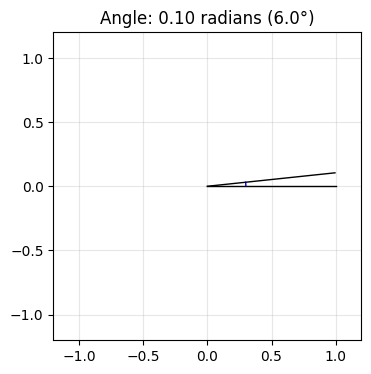

In [194]:
draw_angle(0.105)

In [39]:
np.pi/2

1.5707963267948966

In [138]:
mat1 = np.random.random((3,2))
mat2 = np.random.random((2,4))
mat3 = mat1 @ mat2
vec = np.random.random(4)
print(mat3 @ vec)
print(mat1 @ (mat2 @ vec))
print(mat1 @ mat2 @ vec)

[1.15392195 0.78925163 0.70688412]
[1.15392195 0.78925163 0.70688412]
[1.15392195 0.78925163 0.70688412]
